<a href="https://colab.research.google.com/github/kunai-3txk/colab/blob/main/20220523_BusinessCousalExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ビジネスで利用する因果推論実践 ~アンチパターンを添えて~

https://recruit.gmo.jp/engineer/jisedai/blog/causalinference_antipattern/

データ解析のオーバービュー

データ生成

今回のケースに合致するデータをkaggleで数時間探したが、見つからなかった（マーケティング系のデータって全然ない…）

ユーザーがアプリを開くかどうかを定式化し、その式をもとにデータを生成した

複数手法による施策評価

差の差分法・IPW推定・傾向スコアマッチングを用いて、生成データ内の真のキャンペーン効果を正しく測定できるかを評価

それぞれの評価において、各種手法の弱点をつくような考察を実施

---



まず初めに、ユーザーごとの説明変数とengagementを生成してみます。
以下がサンプルコードです。イメージとしては、各特徴量x1 ~ x4が0 ~ 1の確率値となるように、x1 ~ x4に任意の相関を持たせつつ、その共役事前分布であるベータ分布からデータを生成する感じです。

---



(10000, 6)


,user_id,x1,x2,x3,x4,eng_baseline
0,00001,0.891768,0.550675,0.866984,0.712414,0.323441
1,00002,0.797369,0.517756,0.645640,0.893634,0.350438
2,00003,0.549680,0.440721,0.673795,0.640800,0.432553
3,00004,0.705799,0.444120,0.568811,0.640924,0.335580
4,00005,0.105435,0.265591,0.372221,0.471119,0.577164


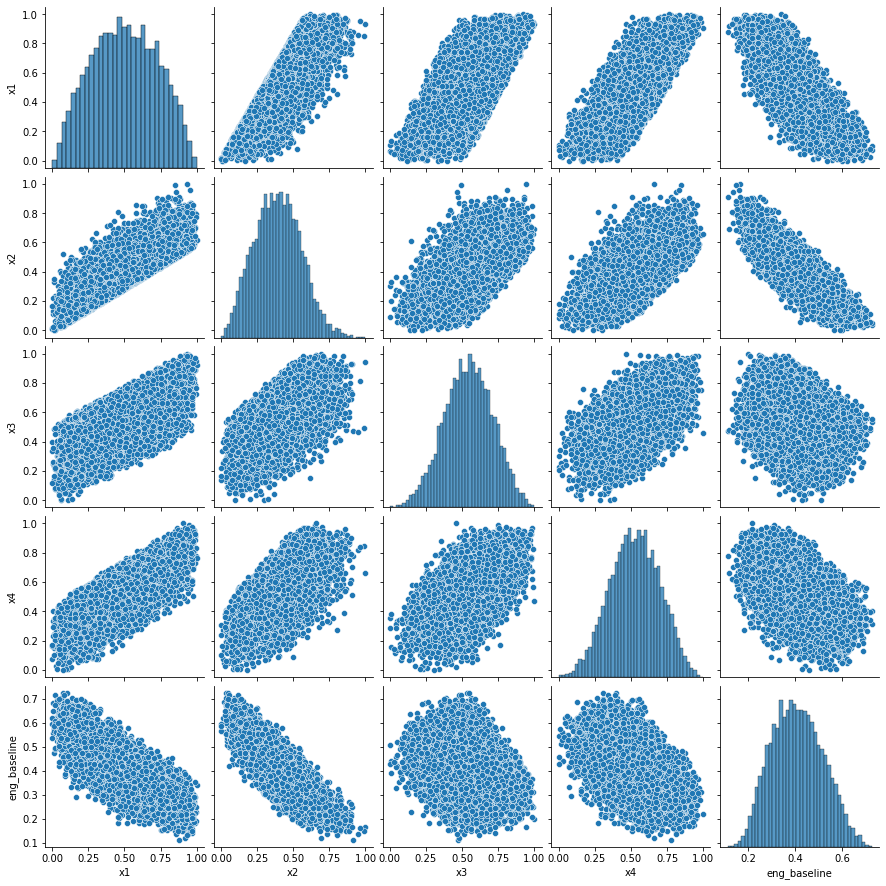

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

def generate_engagement_dataset(n_users=10000):
    '''
    ユーザーの特徴量とengagementを生成する
    '''
    # データ生成時に利用する、特徴量間の相関係数を設定する
    cor_12 = 0.4
    cor_13 = -0.5
    cor_14 = 0.3

    # engagementを定義する真の回帰係数を設定する
    b_0 = 0
    b_1 = -2
    b_2 = -1.7
    b_3 = 1.4
    b_4 = 1

    # engagementにおける変動係数の定義
    # （重畳させるガウシアンノイズの標準偏差が、engagementの平均値の何倍になるかを定義する）
    eps = 0.3


    user_feat = pd.DataFrame()
    user_id = [("0"*len(str(n_users))+str(i+1))[-len(str(n_users)):] for i in range(n_users)]
    user_feat["user_id"] = user_id

    seed_1 = np.random.beta(2, 2, n_users)
    seed_2 = np.random.beta(1, 5, n_users)
    seed_3 = np.random.beta(3, 2, n_users)
    seed_4 = np.random.beta(5, 3, n_users)
    x_1 = seed_1
    x_2 = seed_2 + np.sqrt(1 - cor_12**2) * x_1
    x_3 = seed_3 + np.sqrt(1 - cor_13**2) * x_1
    x_4 = seed_4 + np.sqrt(1 - cor_14**2) * x_1

    scaler = MinMaxScaler()
    user_feat["x1"] = scaler.fit_transform(x_1.reshape(-1, 1))
    user_feat["x2"] = scaler.fit_transform(x_2.reshape(-1, 1))
    user_feat["x3"] = scaler.fit_transform(x_3.reshape(-1, 1))
    user_feat["x4"] = scaler.fit_transform(x_4.reshape(-1, 1))

    user_feat["eng_baseline"] = b_0 + b_1 * user_feat["x1"] + b_2 * user_feat["x2"] + b_3 * user_feat["x3"] + b_4 * user_feat["x4"]

    eng_mean = user_feat["eng_baseline"].mean()
    user_feat["eng_baseline"] += np.random.randn(n_users) * eps*eng_mean
    user_feat["eng_baseline"] = 1/(1+np.exp(-1 * user_feat["eng_baseline"]))

    return user_feat

user_feat = generate_engagement_dataset(n_users=10000)

print(user_feat.shape)
display(user_feat.head())

sns.pairplot(user_feat[["x1","x2","x3","x4","eng_baseline"]])
plt.show();

続いて、ユーザーごとにキャンペーンが適用されるかどうかを、本施策の実施方法「愛着度が低いユーザーほどキャンペーンが適用される確率が高くなるように、全ユーザーの20%にキャンペーンを適用する」に倣って再現してみます。

---



In [4]:
def apply_treatment(e,mean_engagement):
  apply_ratio = 0.2
  assert mean_engagement >= apply_ratio, "error"

  apply_prob =(1-e)*apply_ratio / (1-mean_engagement)
  apply_flg = np.random.binomial(1,apply_prob)

  return apply_flg

effect = 0.05
mean_engagement=user_feat["eng_baseline"].mean() 
user_feat["treated"]=user_feat["eng_baseline"].apply(lambda x:apply_treatment(x,mean_engagement)
)
user_feat["eng_treatment"]=np.clip(user_feat["eng_baseline"]+effect*user_feat["treated"],0,1)


print(user_feat.shape)
display(user_feat.head(10))
print("施策対象ユーザー数：\t{:,}".format((user_feat["eng_baseline"] != user_feat["eng_treatment"]).sum()))
print("施策対象外ユーザー 平均engagement：\t{:.4f}".format((user_feat.loc[user_feat["eng_baseline"] == user_feat["eng_treatment"], "eng_baseline"]).mean()))
print("施策対象ユーザー 平均engagement：\t{:.4f}".format((user_feat.loc[user_feat["eng_baseline"] != user_feat["eng_treatment"], "eng_baseline"]).mean()))
print("施策により上昇した平均engagement：\t{:.4f}".format((user_feat.loc[user_feat["treated"] == 1, "eng_treatment"] - user_feat.loc[user_feat["treated"] == 1, "eng_baseline"]).mean()))

(10000, 8)


,user_id,x1,x2,x3,x4,eng_baseline,treated,eng_treatment
0,00001,0.891768,0.550675,0.866984,0.712414,0.323441,1,0.373441
1,00002,0.797369,0.517756,0.645640,0.893634,0.350438,0,0.350438
2,00003,0.549680,0.440721,0.673795,0.640800,0.432553,1,0.482553
3,00004,0.705799,0.444120,0.568811,0.640924,0.335580,1,0.385580
4,00005,0.105435,0.265591,0.372221,0.471119,0.577164,0,0.577164
5,00006,0.259736,0.265745,0.430915,0.471382,0.502846,0,0.502846
6,00007,0.413799,0.265422,0.589568,0.472963,0.496981,0,0.496981
7,00008,0.380848,0.344118,0.384851,0.484147,0.401178,0,0.401178
8,00009,0.664010,0.411652,0.649884,0.633596,0.378097,0,0.378097
9,00010,0.543213,0.549297,0.454523,0.583407,0.288221,1,0.338221


施策対象ユーザー数：	1,981
施策対象外ユーザー 平均engagement：	0.4148
施策対象ユーザー 平均engagement：	0.3894
施策により上昇した平均engagement：	0.0500


冒頭で、アプリを開くかどうかをengagementと季節要因の作用によって定式化しました。今回は、季節要因の周期Lは60日、aを0.2とすることで、60日間かけて、engagementが0.8 ~ 1倍の振動をするような状況を表現することにしました。この振動により、真のキャンペーン効果は、+0.05 × 0.9(振動平均) = 0.045となります。


---



In [14]:
L=60 #60日
a=0.2 #0.8～1.0の振動
e_1=0.0

df_days=pd.DataFrame(np.arange(L),columns=["date"])
df_days["join_key"]=1
df_days["seasonal"]=((np.cos(2*np.pi/L * df_days["date"])-1)/2+np.random.randn(len(df_days))*e_1)*a+1

user_history = user_feat[["user_id", "eng_baseline", "eng_treatment"]].copy()
user_history["join_key"] = 1

user_history = pd.merge(df_days, user_history, on='join_key', how='outer')
user_history.drop(columns=["join_key"], inplace=True)

user_history["before_after"] = 0
user_history.loc[user_history["date"]>=L/2, "before_after"] = 1

user_history["eng"] = user_history["eng_baseline"]
user_history.loc[user_history["before_after"]>=1, "eng"] = user_history.loc[user_history["before_after"]>=1, "eng_treatment"]

user_history["prob"] = np.clip(user_history["eng"] * user_history["seasonal"], 0, 1)
user_history["observe"] = np.random.binomial(1, user_history["prob"])

user_history = pd.merge(user_history, user_feat[["user_id", "treated"]], on="user_id", how="left")

ここで生成されたuser_historyテーブルは、ユーザーごとに60日分の結果を再現しているので10,000 × 60行のテーブルになっています。また、その日にアプリを開いたかどうかはuser_history["observe"]に格納されていて、engagementと季節要因で作成された確率pのベルヌーイ試行と考え生成されたものになります。
e_1は後の実験で季節要因に摂動を加えたくなったとき用に組み込んでおきます。

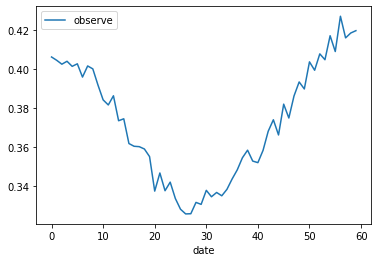

In [15]:
x = user_history.groupby("date")[["observe"]].mean()
x.plot()
plt.show();

ここで、現場でよく行われる前後比較の分析をしてみたらどうなるか、試してみましょう。解析結果は、「0 ~ 30日でのトレンドがこのまま続くとすると、赤い点線のようなダウントレンドだったはずのものが、キャンペーン適用により大幅に改善した」というものになります。果たしてこれはどれほど再現性がある分析なのでしょうか…？

3. 差の差分法（DID）
基本形
キャンペーンが適用されたユーザーと、適用されなかったユーザーの2群に分けることで効果を測定するのがDIDの手法でした。
まずはグラフ化することで、先ほど登場したV字回復グラフの中身を簡単に探ってみることにしましょう。

---



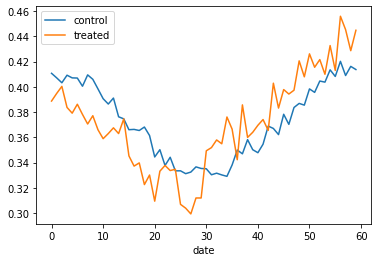

In [16]:
data_0 = user_history[user_history["treated"]==0].groupby("date")[["observe"]].mean()
data_0.reset_index(drop=False, inplace=True)
data_1 = user_history[user_history["treated"]==1].groupby("date")[["observe"]].mean()
data_1.reset_index(drop=False, inplace=True)
plt.plot(data_0["date"], data_0["observe"], label="control")
plt.plot(data_1["date"], data_1["observe"], label="treated")
plt.xlabel("date")
plt.legend()
plt.show();

In [17]:
did_result = user_history.groupby(["treated", "before_after"])[["observe"]].agg(["count","mean","var"])
display(did_result)

observe                    
                       count      mean       var
treated before_after                            
0       0             240570  0.372765  0.233812
        1             240570  0.372889  0.233844
1       0              59430  0.350294  0.227592
        1              59430  0.393791  0.238724

結果は、0.0416 (±0.0061)となりました。

---



アンチパターン
DIDは、その分析を成立させるため、平行トレンド仮定を置いていました。ここでは、その平行トレンドが成立しないケースでどのような推定を行ってしまうのか、確認してみましょう。

平行トレンドでないシチュエーションとして、データ生成時にアプリを開くかどうかの確率に、実はengagementも作用している場合を考えます。コードとしては、2. 実験データ作成の3つ目のコードブロック21行目を以下のように書き換えます。

---



user_history["prob"] = np.clip(user_history["eng"] * user_history["seasonal"] - user_history["date"] * user_history["eng_baseline"]*0.2/L, 0, 1)

4. IPW推定
基本形
キャンペーンが適用されるかどうかを何らかのモデルで表現し（= 傾向スコア）、その逆重み付けで効果を推定するのがIPW推定でした。以下の式が効果の推定量となるので、これまで作成してきたデータに当てはめてみましょう。

---



一つ足りないパーツとして、ユーザーごとにキャンペーンが適用されるかどうかの傾向スコアを作成しなければなりません。
次のコードでは、上記で作成したx1 ~ x4を共変量として、statsmodelsでロジスティック回帰モデルのパラメータを推定した後、作成された傾向スコアをもとに効果の推定と、標準誤差を求めています。標準誤差は、残差の重み付け平方和を取る形での実装となります。

In [18]:
import statsmodels.api as sm
# ロジスティック回帰モデルの作成
df = user_feat[["x1","x2","x3","x4","treated"]].copy()
df = sm.add_constant(df)
logit_mod = sm.Logit(df[["treated"]], df[["const","x1","x2","x3","x4"]], family=sm.families.Gamma())
logit_res = logit_mod.fit(method="newton")
print(logit_res.summary())
# モデルの出力結果を傾向スコアとしてテーブル化
res = pd.DataFrame()
res["user_id"] = user_feat["user_id"]
res["propensity"] = logit_mod.endog - logit_res.resid_response
ipw_data = user_history[["user_id", "before_after", "treated", "observe"]].copy()
ipw_data = ipw_data[ipw_data["before_after"]==1]
ipw_data = pd.merge(ipw_data, res, on="user_id", how="inner")
# 定義に従ってIPW推定量を計算
cond_e1 = ipw_data["treated"]==1
E_1 = ((1 / ipw_data.loc[cond_e1, "propensity"])*ipw_data.loc[cond_e1, "observe"]).sum() / (1 / ipw_data.loc[cond_e1, "propensity"]).sum()
cond_e0 = ipw_data["treated"]==0
E_0 = ((1 / (1 - ipw_data.loc[cond_e0, "propensity"]))*ipw_data.loc[cond_e0, "observe"]).sum() / (1 / (1 - ipw_data.loc[cond_e0, "propensity"])).sum()
ipw_data["residual"] = 0
ipw_data.loc[ipw_data["observe"]==1, "square_error"] = ipw_data["propensity"] * np.power(ipw_data["observe"] - E_1, 2)
ipw_data.loc[ipw_data["observe"]==0, "square_error"] = ipw_data["propensity"] * np.power(ipw_data["observe"] - E_0, 2)
se = np.sqrt(
    ipw_data.loc[ipw_data["observe"]==1, "square_error"].sum()/np.power((ipw_data.loc[ipw_data["observe"]==1, "propensity"]).sum(), 2) + 
    ipw_data.loc[ipw_data["observe"]==0, "square_error"].sum()/np.power((ipw_data.loc[ipw_data["observe"]==0, "propensity"]).sum(), 2)
    )
print(E_1 - E_0)
print(se * 1.96)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.493883
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                treated   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Mon, 23 May 2022   Pseudo R-squ.:                0.007783
Time:                        14:05:35   Log-Likelihood:                -4938.8
converged:                       True   LL-Null:                       -4977.6
Covariance Type:            nonrobust   LLR p-value:                 5.962e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5911      0.103    -15.375      0.000      -1.794      -1.388
x1             1.0646      0.